In [4]:
# 1. 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# 设置中文显示
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [5]:
# 2. 加载数据
data = pd.read_excel(r'C:\Users\admin\Desktop\injury_data.xlsx')

# 查看数据基本信息
print("数据基本信息：")
data.info()

# 查看数据集行数和列数
rows, columns = data.shape

print("数据前几行内容信息：")
print(data.head().to_csv(sep='\t', na_rep='nan'))

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player_Age            1000 non-null   int64  
 1   Player_Weight         1000 non-null   float64
 2   Player_Height         1000 non-null   float64
 3   Previous_Injuries     1000 non-null   int64  
 4   Training_Intensity    1000 non-null   float64
 5   Recovery_Time         1000 non-null   int64  
 6   Likelihood_of_Injury  1000 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 54.8 KB
数据前几行内容信息：
	Player_Age	Player_Weight	Player_Height	Previous_Injuries	Training_Intensity	Recovery_Time	Likelihood_of_Injury
0	24	66.25193286255299	175.73242883117646	1	0.4579289944340279	5	0
1	37	70.99627126832448	174.58165012331358	0	0.2265216260361057	6	1
2	32	80.09378116336106	186.32961751509828	0	0.6139703063252326	2	1
3	28	87.47327055231725	175.50423961774715	1	0.2528581

In [8]:
# 3. 数据预处理-检查缺失值
missing_values = data.isnull().sum()

if missing_values.sum() > 0:
    print("\n缺失值情况：")
    print(missing_values)
    
    # 处理缺失值（用均值填充数值型缺失值）
    for column in data.columns:
        if data[column].isnull().sum() > 0:
            if data[column].dtype in [np.float64, np.int64]:
                data[column] = data[column].fillna(data[column].mean())
            else:
                data[column] = data[column].fillna(data[column].mode()[0])
    
    print("\n处理后缺失值情况：")
    print(data.isnull().sum())
else:
    print("\n数据无缺失值")


数据无缺失值


In [10]:
# 4. 数据探索性分析-描述性统计
print("\n描述性统计（数值型特征）：")
print(data.select_dtypes(include=[np.number]).describe().round(2))


描述性统计（数值型特征）：
       Player_Age  Player_Weight  Player_Height  Previous_Injuries  \
count     1000.00        1000.00        1000.00            1000.00   
mean        28.23          74.79         179.75               0.52   
std          6.54           9.89           9.89               0.50   
min         18.00          40.19         145.29               0.00   
25%         22.00          67.94         173.04               0.00   
50%         28.00          75.02         180.03               1.00   
75%         34.00          81.30         186.56               1.00   
max         39.00         104.65         207.31               1.00   

       Training_Intensity  Recovery_Time  Likelihood_of_Injury  
count             1000.00        1000.00                1000.0  
mean                 0.49           3.47                   0.5  
std                  0.29           1.70                   0.5  
min                  0.00           1.00                   0.0  
25%                  0.24    

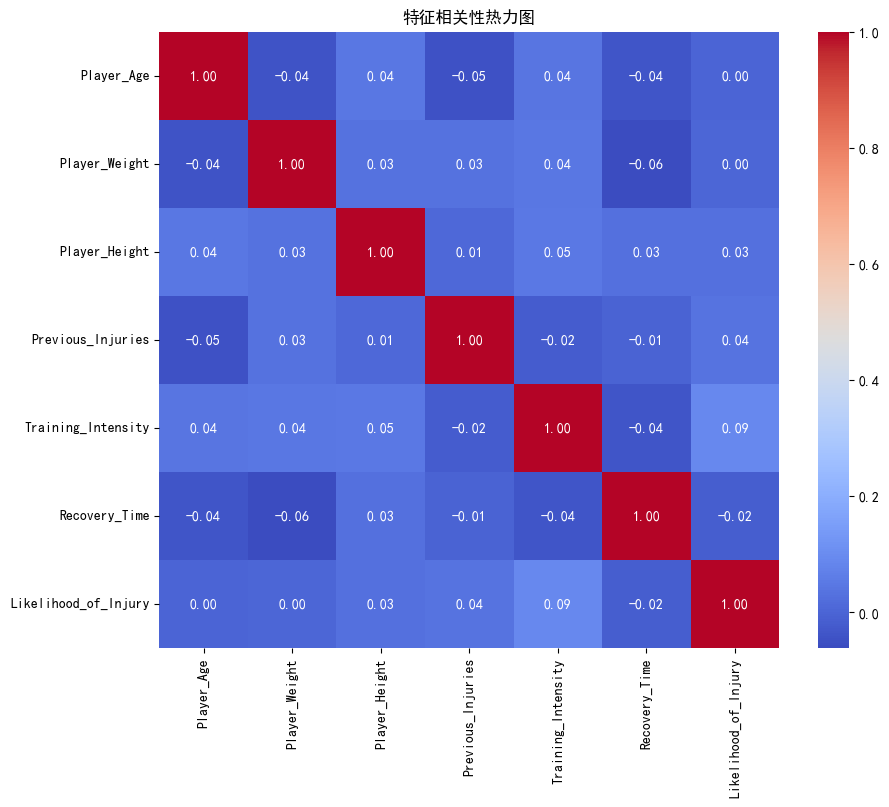


与受伤可能性的相关性排序：
Likelihood_of_Injury    1.000000
Training_Intensity      0.089250
Previous_Injuries       0.038017
Player_Height           0.029639
Player_Weight           0.001843
Player_Age              0.000153
Recovery_Time          -0.015292
Name: Likelihood_of_Injury, dtype: float64


In [12]:
# 5. 数据探索性分析-相关性分析
correlation = data.corr()

# 显示负号
plt.rcParams['axes.unicode_minus'] = False

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('特征相关性热力图')
plt.show()

# 查看与受伤可能性的相关性排序
print("\n与受伤可能性的相关性排序：")
print(correlation['Likelihood_of_Injury'].sort_values(ascending=False))

In [19]:
# 6. 数据探索性分析-单因素分析（T检验）
group1 = data[data['Likelihood_of_Injury'] == 1]
group2 = data[data['Likelihood_of_Injury'] == 0]

t_test_results = {}
for column in data.select_dtypes(include=[np.number]).columns:
    if column != 'Likelihood_of_Injury':
        t_stat, p_value = stats.ttest_ind(group1[column], group2[column])
        t_test_results[column] = {'t-statistic': t_stat, 'p-value': p_value}

# 转换为DataFrame并显示结果（按p值排序）
t_test_df = pd.DataFrame(t_test_results).T
t_test_df.sort_values('p-value', inplace=True)
print("\nT检验结果（按p值排序）：")
print(t_test_df.round(4))


T检验结果（按p值排序）：
                    t-statistic  p-value
Training_Intensity       2.8308   0.0047
Previous_Injuries        1.2019   0.2297
Player_Height            0.9367   0.3491
Recovery_Time           -0.4831   0.6291
Player_Weight            0.0582   0.9536
Player_Age               0.0048   0.9961


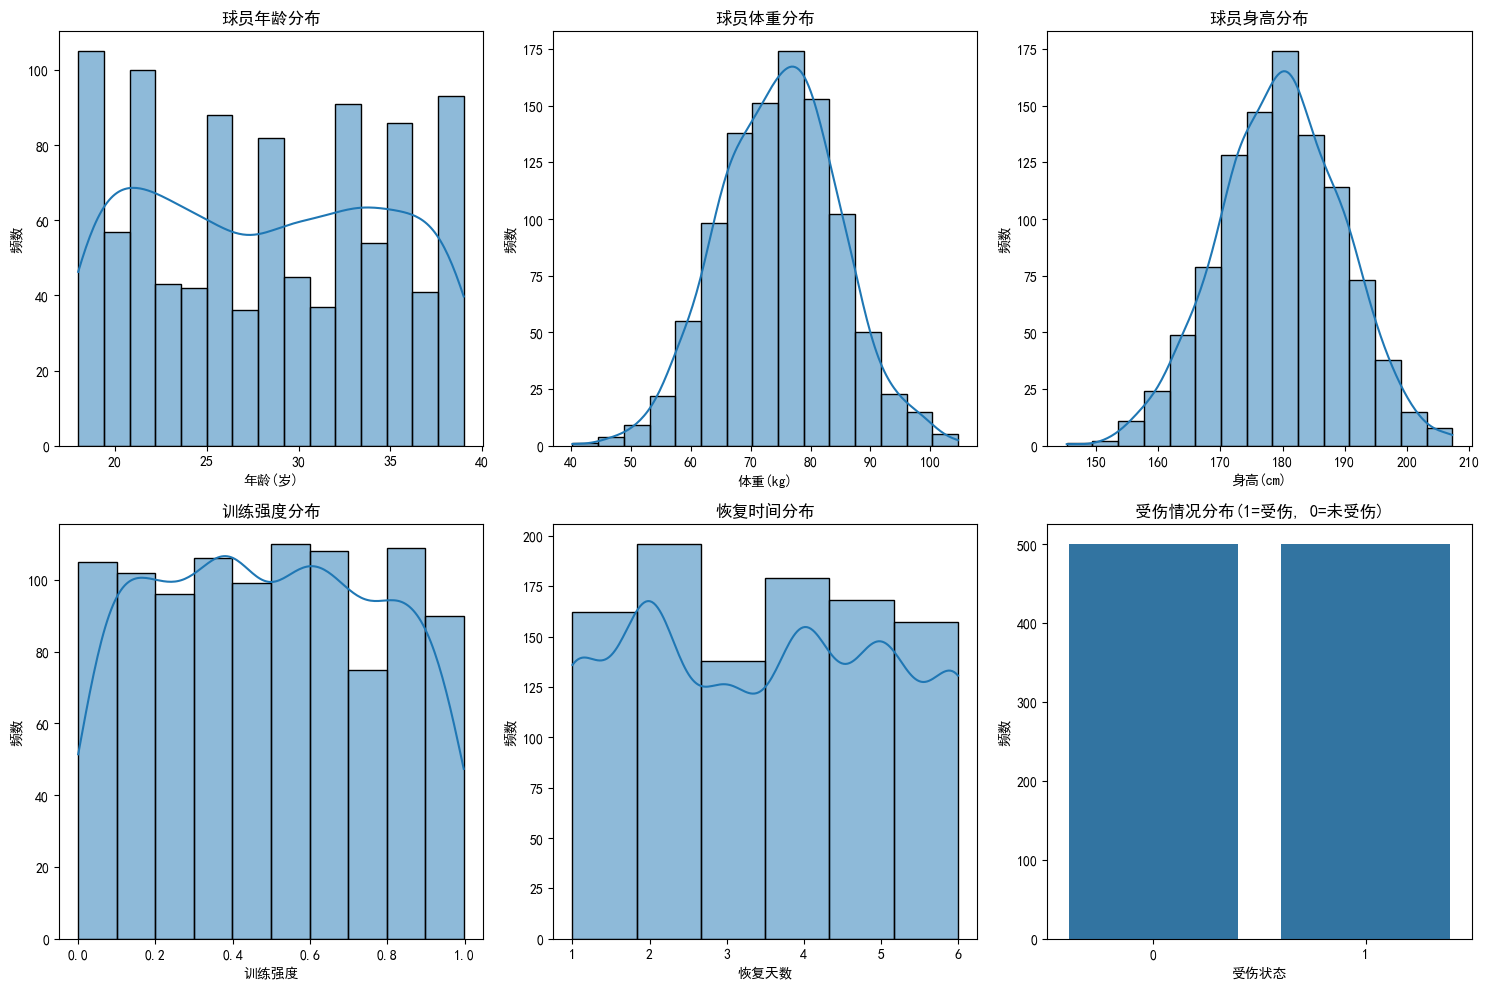

In [21]:
# 7. 探索性数据分析与可视化增强
# 7.1数据探索性分析-单变量分布可视化
plt.figure(figsize=(15, 10))

# (1)年龄分布
plt.subplot(2, 3, 1)
sns.histplot(data['Player_Age'], kde=True, bins=15)
plt.title('球员年龄分布')
plt.xlabel('年龄(岁)')
plt.ylabel('频数')

# (2)体重分布
plt.subplot(2, 3, 2)
sns.histplot(data['Player_Weight'], kde=True, bins=15)
plt.title('球员体重分布')
plt.xlabel('体重(kg)')
plt.ylabel('频数')

# (3)身高分布
plt.subplot(2, 3, 3)
sns.histplot(data['Player_Height'], kde=True, bins=15)
plt.title('球员身高分布')
plt.xlabel('身高(cm)')
plt.ylabel('频数')

# (4)训练强度分布
plt.subplot(2, 3, 4)
sns.histplot(data['Training_Intensity'], kde=True, bins=10)
plt.title('训练强度分布')
plt.xlabel('训练强度')
plt.ylabel('频数')

# (5)恢复时间分布
plt.subplot(2, 3, 5)
sns.histplot(data['Recovery_Time'], kde=True, bins=6)
plt.title('恢复时间分布')
plt.xlabel('恢复天数')
plt.ylabel('频数')

# (6)受伤情况分布
plt.subplot(2, 3, 6)
sns.countplot(x='Likelihood_of_Injury', data=data)
plt.title('受伤情况分布(1=受伤, 0=未受伤)')
plt.xlabel('受伤状态')
plt.ylabel('频数')

plt.tight_layout()
plt.show()

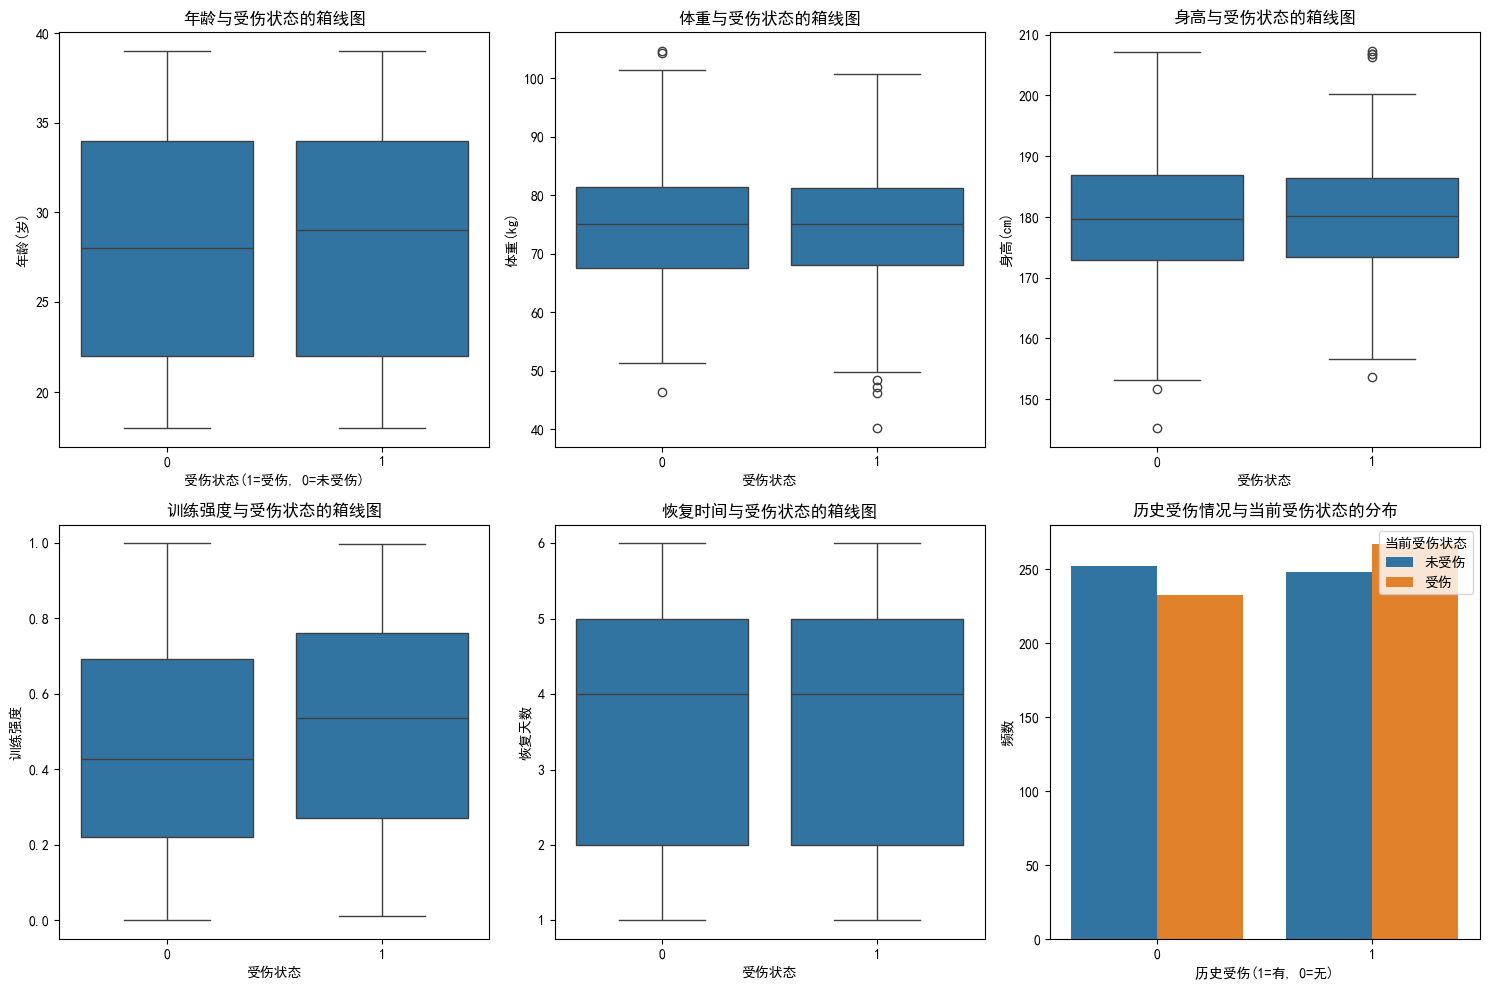

In [23]:
# 7.2分组对比可视化-受伤与未受伤组特征差异
plt.figure(figsize=(15, 10))

# (1)年龄对比
plt.subplot(2, 3, 1)
sns.boxplot(x='Likelihood_of_Injury', y='Player_Age', data=data)
plt.title('年龄与受伤状态的箱线图')
plt.xlabel('受伤状态(1=受伤, 0=未受伤)')
plt.ylabel('年龄(岁)')

# (2)体重对比
plt.subplot(2, 3, 2)
sns.boxplot(x='Likelihood_of_Injury', y='Player_Weight', data=data)
plt.title('体重与受伤状态的箱线图')
plt.xlabel('受伤状态')
plt.ylabel('体重(kg)')

# (3)身高对比
plt.subplot(2, 3, 3)
sns.boxplot(x='Likelihood_of_Injury', y='Player_Height', data=data)
plt.title('身高与受伤状态的箱线图')
plt.xlabel('受伤状态')
plt.ylabel('身高(cm)')

# (4)训练强度对比
plt.subplot(2, 3, 4)
sns.boxplot(x='Likelihood_of_Injury', y='Training_Intensity', data=data)
plt.title('训练强度与受伤状态的箱线图')
plt.xlabel('受伤状态')
plt.ylabel('训练强度')

# (5)恢复时间对比
plt.subplot(2, 3, 5)
sns.boxplot(x='Likelihood_of_Injury', y='Recovery_Time', data=data)
plt.title('恢复时间与受伤状态的箱线图')
plt.xlabel('受伤状态')
plt.ylabel('恢复天数')

# (6)历史受伤情况对比
plt.subplot(2, 3, 6)
sns.countplot(x='Previous_Injuries', hue='Likelihood_of_Injury', data=data)
plt.title('历史受伤情况与当前受伤状态的分布')
plt.xlabel('历史受伤(1=有, 0=无)')
plt.ylabel('频数')
plt.legend(title='当前受伤状态', labels=['未受伤', '受伤'])

plt.tight_layout()
plt.show()

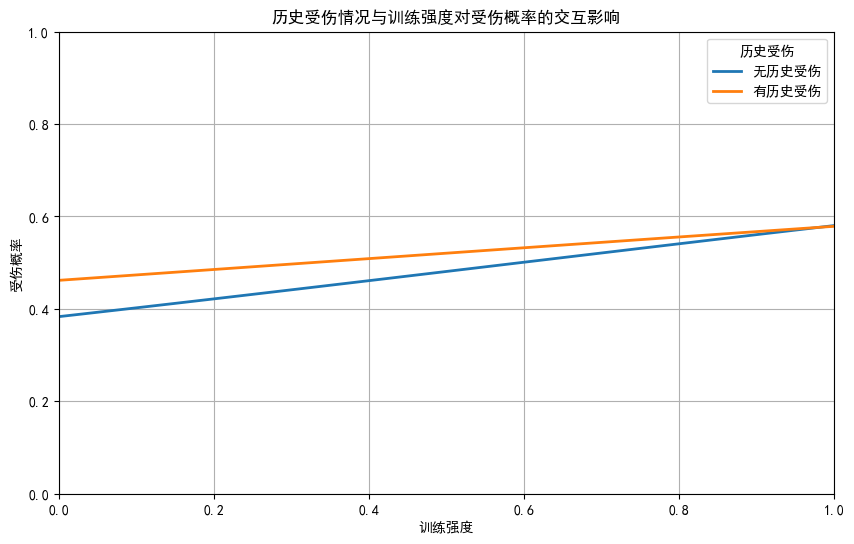

▶ 监控训练强度            受伤组的平均训练强度（0.52）高于未受伤组（0.47）。
建议：                     使用心率监测设备实时监控训练强度，避免单日强度超过0.7。
       采用周期化训练策略，将高强度训练与中低强度训练交替安排。

▶ 注意体重管理           受伤组平均体重（74.81kg）比未受伤组（74.78kg）高。
建议：                     结合BMI指数制定体重管理目标，控制在20-25之间。
       体重超标的运动员通过专业营养师制定饮食计划。

▶ 历史受伤预防           有历史受伤记录的运动员当前受伤概率为0.518，高于无历史受伤者（0.48）。
建议：                     对有历史受伤记录的运动员，训练前针对受伤部位进行专项激活训练。
       引入功能性动作筛查（FMS），制定矫正训练计划降低二次受伤风险。

▶ 身高相关防护           身高超过186.6cm的运动员受伤风险较高。
建议：                     加强核心稳定性训练（如平板支撑、悬吊训练）。
       跳跃类运动中注意膝盖 alignment，通过弹力带训练强化发力模式。

                                    训练建议总结：                                     
- 训练强度：监控阈值0.7，周期化训练
- 体重管理：BMI控制在20-25，专业饮食计划
- 历史伤病：旧伤部位专项激活，FMS筛查
- 身高防护：核心稳定性训练，跳跃动作控制


In [40]:
# 7.3 历史受伤情况与训练强度的交互作用
import statsmodels.api as sm  

plt.figure(figsize=(10, 6))

# 按历史受伤情况分组
for injury_status, group in data.groupby('Previous_Injuries'):
    # 逻辑回归拟合
    X = sm.add_constant(group['Training_Intensity'])
    y = group['Likelihood_of_Injury']
    model = sm.Logit(y, X).fit(disp=0)
    
    # 生成预测数据
    train_intensity_range = np.linspace(0, 1, 100)
    X_pred = sm.add_constant(train_intensity_range)
    pred_proba = model.predict(X_pred)
    
    # 绘制曲线
    label = '有历史受伤' if injury_status == 1 else '无历史受伤'
    plt.plot(train_intensity_range, pred_proba, label=label, linewidth=2)

plt.title('历史受伤情况与训练强度对受伤概率的交互影响')
plt.xlabel('训练强度')
plt.ylabel('受伤概率')
plt.legend(title='历史受伤')
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


# (1) 训练强度管理建议
train_intensity_msg = f"受伤组的平均训练强度（{group1['Training_Intensity'].mean():.2f}）高于未受伤组（{group2['Training_Intensity'].mean():.2f}）。"
print(f"▶ 监控训练强度".ljust(20) + f"{train_intensity_msg}")
print("建议：".ljust(24) + "使用心率监测设备实时监控训练强度，避免单日强度超过0.7。\n"
      "       采用周期化训练策略，将高强度训练与中低强度训练交替安排。")

# (2) 体重管理建议
weight_msg = f"受伤组平均体重（{group1['Player_Weight'].mean():.2f}kg）比未受伤组（{group2['Player_Weight'].mean():.2f}kg）高。"
print("\n▶ 注意体重管理".ljust(20) + f"{weight_msg}")
print("建议：".ljust(24) + "结合BMI指数制定体重管理目标，控制在20-25之间。\n"
      "       体重超标的运动员通过专业营养师制定饮食计划。")

# (3) 历史受伤预防建议
prev_injury_msg = f"有历史受伤记录的运动员当前受伤概率为{prev_injury_rate[1]}，高于无历史受伤者（{prev_injury_rate[0]}）。"
print("\n▶ 历史受伤预防".ljust(20) + f"{prev_injury_msg}")
print("建议：".ljust(24) + "对有历史受伤记录的运动员，训练前针对受伤部位进行专项激活训练。\n"
      "       引入功能性动作筛查（FMS），制定矫正训练计划降低二次受伤风险。")

# (4) 身高相关建议
height_msg = f"身高超过{data['Player_Height'].quantile(0.75):.1f}cm的运动员受伤风险较高。"
print("\n▶ 身高相关防护".ljust(20) + f"{height_msg}")
print("建议：".ljust(24) + "加强核心稳定性训练（如平板支撑、悬吊训练）。\n"
      "       跳跃类运动中注意膝盖 alignment，通过弹力带训练强化发力模式。")

print("\n" + "="*80)
print("训练建议总结：".center(80))
print("="*80)
print("- 训练强度：监控阈值0.7，周期化训练")
print("- 体重管理：BMI控制在20-25，专业饮食计划")
print("- 历史伤病：旧伤部位专项激活，FMS筛查")
print("- 身高防护：核心稳定性训练，跳跃动作控制")

In [42]:
# 8. 特征工程-划分特征和目标变量
X = data.drop('Likelihood_of_Injury', axis=1)
y = data['Likelihood_of_Injury']

In [66]:
# 9. 特征工程-标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 数据划分-训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [68]:
# 10. 模型训练-支持向量机(SVM)
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [70]:
# 11. 模型评估-支持向量机
svm_train_pred = svm_model.predict(X_train)
svm_test_pred = svm_model.predict(X_test)

print("\n支持向量机模型评估：")
print("准确率：", accuracy_score(y_train, svm_train_pred))


支持向量机模型评估：
准确率： 0.6471428571428571


In [72]:
# 12. 模型训练-K最近邻(KNN)
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# 13. 模型评估-K最近邻
knn_train_pred = knn_model.predict(X_train)
knn_test_pred = knn_model.predict(X_test)

print("\nK最近邻模型评估：")
print("准确率：", accuracy_score(y_train, knn_train_pred))


K最近邻模型评估：
准确率： 0.7028571428571428


In [76]:
# 14. 模型训练-梯度提升机(GBM)
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# 15. 模型评估-梯度提升机
gbm_train_pred = gbm_model.predict(X_train)
gbm_test_pred = gbm_model.predict(X_test)

print("\n梯度提升机模型评估：")
print("准确率：", accuracy_score(y_train, gbm_train_pred))


梯度提升机模型评估：
准确率： 0.8557142857142858
